## Job Generation

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import csv

## Constants

In [22]:
# number of jobs
n = 10000
number_of_queues = 4
lmbda = 0.1
mu = 0.2
filePath = "jobs.csv"

In [23]:
jobsArray = []

class Job:
    def __init__(self, arrival_time, service_time, priority):
        self.priority = priority
        self.arrival_time = arrival_time
        self.service_time = service_time
        self.waiting_time = 0
        self.sojourn_time = 0
        self.departure = None
        self.first_service = None
        self.isJobDone = False

def load_jobs_from_csv(file_path):
    jobs = []
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # Skip header if present
        for row in csv_reader:
            arrival_time, service_time, priority = map(float, row)
            job = Job(arrival_time, service_time, priority)
            jobs.append(job)
    return jobs
        
def generate_exponential_xi(n, lmbda):
    y = np.random.uniform(0, 1, n)
    x = [-np.log(1 - y[i]) / lmbda for i in range(len(y))]
    return x

def generate_si_sigma_xi(n):
    n_sorted = sorted(n)
    si_sigma_xi = []
    for i in range(len(n_sorted)):
        si_sigma_xi.append(sum(n_sorted[:i+1]))
    return si_sigma_xi

def generate_sizes(si_sigma_xi, mu):
    sizes = generate_exponential_xi(len(si_sigma_xi), mu)
    jobs = []
    for i in range(len(si_sigma_xi)):
        jobs.append(Job(si_sigma_xi[i], sizes[i], None))
    return jobs

def assign_priority(jobsArray, number_of_queues, average_service_time):
    bin_size = 2 * average_service_time / number_of_queues
    for job in jobsArray:
        priority = int(job.service_time / bin_size)
        if priority >= number_of_queues:
            priority = number_of_queues - 1
        job.priority = priority
    return jobsArray

def areJobsLeft(jobsArray):
    for job in jobsArray:
        if job.isJobDone == False:   
            return True
    return False

def getHighestPriorityJob(jobsArray,global_clock):
    index = -1
    priority = 100000
    for i, job in enumerate(jobsArray):
        if job.priority <= priority and global_clock >= job.arrival_time and job.isJobDone == False:
            priority = job.priority
            index = i 
            
    return index

def getNextJobArrival(jobsArray):
    index = -1
    for i, job in enumerate(jobsArray):
        if job.isJobDone == False:
            return i
    return None  

def simulate_queue(jobsArray,numJobs):
    global_clock = 0
    numJobsdone = 0
    while numJobsdone != numJobs:
        
        highest_priority_job_index = getHighestPriorityJob(jobsArray,global_clock)
        
        if highest_priority_job_index == -1:
            index =  getNextJobArrival(jobsArray)
            if index is None:
                break
            global_clock = jobsArray[index].arrival_time
            highest_priority_job_index = index

        currJob = jobsArray[highest_priority_job_index]  
        jobsArray[highest_priority_job_index].isJobDone = True 
        jobsArray[highest_priority_job_index].first_service = global_clock
        jobsArray[highest_priority_job_index].waiting_time = global_clock -  jobsArray[highest_priority_job_index].arrival_time
        jobsArray[highest_priority_job_index].sojourn_time = jobsArray[highest_priority_job_index].waiting_time + jobsArray[highest_priority_job_index].service_time
        global_clock += currJob.service_time  
        jobsArray[highest_priority_job_index].departure = global_clock
        numJobsdone += 1



## Queuing parameters

In [24]:
xi = generate_exponential_xi(n, lmbda)
si_sigma_xi = generate_si_sigma_xi(xi)
jobsArray = generate_sizes(si_sigma_xi, mu)
jobsArray = assign_priority(jobsArray, number_of_queues, 1/mu)
    
# Count number of jobs in each queue
count = [0] * number_of_queues
for job in jobsArray:
    count[job.priority] += 1
print("Counts per priority:", count)

jobsArray = load_jobs_from_csv(filePath)

# Simulate the queue with the given arrival times and sizes using sjf
simulate_queue(jobsArray,n)


Counts per priority: [3864, 2432, 1451, 2253]


In [25]:

print("Jobs:")
for job in jobsArray:
    print("Arrival Time:", job.arrival_time, "Service Time:", job.service_time, "Priority:", job.priority, "Waiting Time:", job.waiting_time, "Sojourn Time:", job.sojourn_time)


Jobs:
Arrival Time: 0.0012021196833413184 Service Time: 6.321905544188941 Priority: 2.0 Waiting Time: 0.0 Sojourn Time: 6.321905544188941
Arrival Time: 0.04054480713762938 Service Time: 0.4178827254332538 Priority: 0.0 Waiting Time: 19.33776498597884 Sojourn Time: 19.755647711412095
Arrival Time: 0.1368512026761433 Service Time: 0.47180270923761675 Priority: 0.0 Waiting Time: 18.769655881202706 Sojourn Time: 19.241458590440324
Arrival Time: 0.28941914905274013 Service Time: 6.435369412694949 Priority: 2.0 Waiting Time: 61.376920034563184 Sojourn Time: 67.81228944725814
Arrival Time: 0.5020713211573196 Service Time: 1.9865185545893034 Priority: 0.0 Waiting Time: 16.417917208132227 Sojourn Time: 18.40443576272153
Arrival Time: 0.7297254321151987 Service Time: 14.444944909006349 Priority: 3.0 Waiting Time: 272.7160051747789 Sojourn Time: 287.1609500837852
Arrival Time: 1.1652502673317868 Service Time: 0.7661123323542908 Priority: 0.0 Waiting Time: 14.98862592960347 Sojourn Time: 15.754738

## Average Time for simulation

In [26]:

def getAverageServiceTime(jobsArray):
    totserviceTime = 0
    for job in jobsArray:
        totserviceTime += job.service_time
    avg_time = totserviceTime/len(jobsArray)
    return avg_time    

def getAverageWaitingTime(jobsArray):
    totWaitingTime = 0
    for job in jobsArray:
        totWaitingTime += job.waiting_time
    avg_time = totWaitingTime/len(jobsArray)
    return avg_time  

def getAverageSojournTime(jobsArray):
    totSojournTime = 0
    for job in jobsArray:
        totSojournTime += job.sojourn_time
    avg_time = totSojournTime/len(jobsArray)
    return avg_time 

print(getAverageServiceTime(jobsArray))
print(getAverageWaitingTime(jobsArray))
print(getAverageSojournTime(jobsArray))


4.672213325770113
22.359035811740437
27.031249137510564


## Waiting Times Vs Arrival

[(0.0012021196833413184, 0.0, 2.0), (0.04054480713762938, 19.33776498597884, 0.0), (0.1368512026761433, 18.769655881202706, 0.0), (0.28941914905274013, 61.376920034563184, 2.0), (0.5020713211573196, 16.417917208132227, 0.0), (0.7297254321151987, 272.7160051747789, 3.0), (1.1652502673317868, 14.98862592960347, 0.0), (1.739690222650781, 12.5659476961129, 0.0), (2.3951962508341116, 261.8210750632614, 3.0), (3.174254064277937, 3.5058957889096414, 0.0), (3.9681871589193953, 249.618506104467, 3.0), (4.8459465956331815, 51.10380081495649, 2.0), (5.8127165144025446, 0.5103911494697382, 0.0), (6.822078608961084, 7.465580451977017, 0.0), (7.934092279246771, 0.8313426005729578, 0.0), (9.096036604195458, 14.517838959004205, 1.0), (10.274258403305927, 0.7088210967838258, 0.0), (11.463902995366695, 1.7754889142821195, 0.0), (12.6737573984772, 7.122435120072524, 1.0), (14.185955257898332, 225.1830551912602, 3.0), (15.775763334456661, 0.2436017843590772, 0.0), (17.379682825236387, 193.19225826994867, 

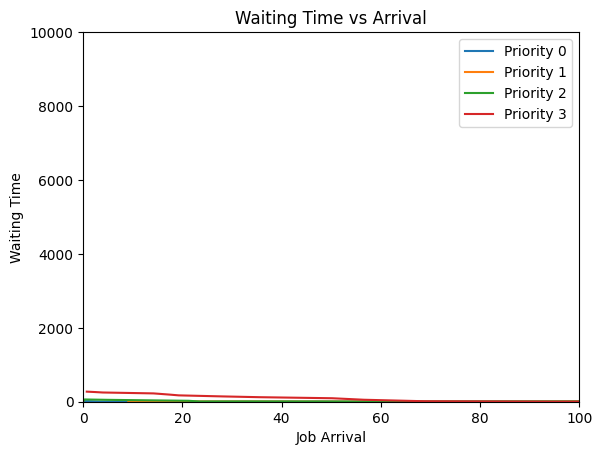

In [27]:
waitingTimesArray = []

for i, job in enumerate(jobsArray):
    waitingTimesArray.append((job.arrival_time,job.waiting_time,job.priority))
    
print(waitingTimesArray)

priority_data = {}
for arrival_time, waiting_time, priority in waitingTimesArray:
    if priority not in priority_data:
        priority_data[priority] = {'arrival_time': [], 'waiting_time': []}
    priority_data[priority]['arrival_time'].append(arrival_time)
    priority_data[priority]['waiting_time'].append(waiting_time)

for priority in range(4):
    if priority in priority_data:
        data = priority_data[priority]
        plt.plot(data['arrival_time'], data['waiting_time'], label=f'Priority {priority}')

plt.xlabel('Job Arrival')
plt.ylabel('Waiting Time')
plt.ylim([0,10000])
plt.xlim([0,100])
plt.title('Waiting Time vs Arrival')
plt.legend()
plt.show()

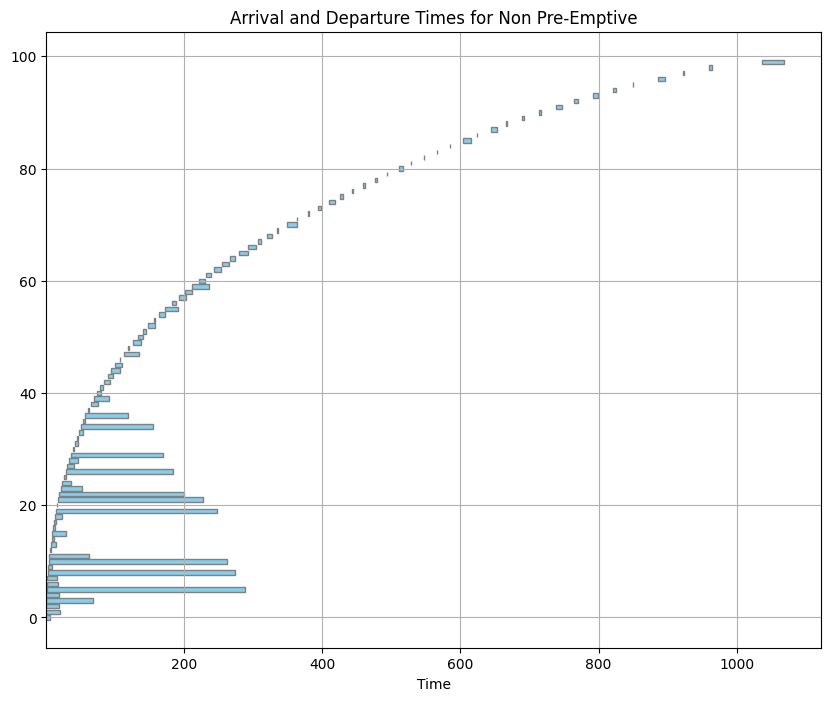

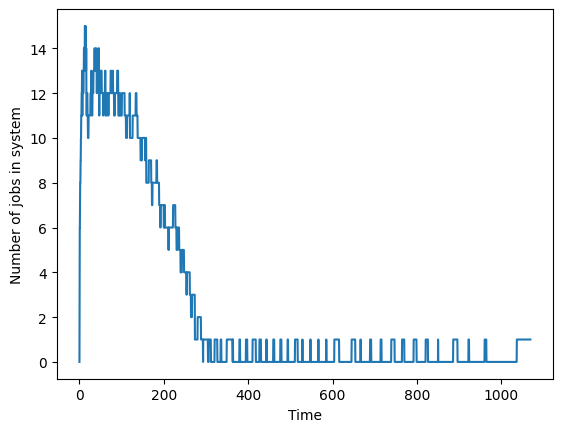

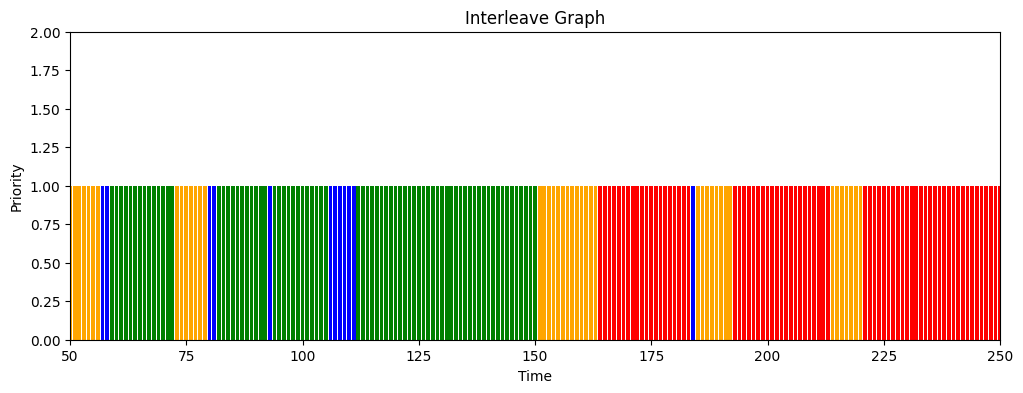

In [32]:
def plot_time_for_each_job_barh(jobsArray):
    arrival_times = []
    duration = []
    index = []
    count = 0
    for i in jobsArray:
        arrival_times.append(i.arrival_time)
        duration.append(i.service_time + i.waiting_time)
        index.append(count)
        count += 1
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(index, duration, left=arrival_times, color='skyblue', edgecolor='grey')
    ax.set_xlabel('Time')
    ax.set_title('Arrival and Departure Times for Non Pre-Emptive')
    plt.grid(True)
    plt.show()

def number_of_jobs_in_system_at_any_time(jobsArray):
    arrival_times = []
    departure = []
    timestamps=[]
    counts = []
    unit_time = 0.25
    time = 0
    for i in jobsArray:
        arrival_times.append(i.arrival_time)
        departure.append(i.arrival_time + i.service_time + i.waiting_time)
    while(time<max(departure)):
        timestamps.append(time)
        arrivals = 0
        departures = 0
        for atime in arrival_times:
            if atime<time:
                arrivals+=1
        for dtime in departure:
            if dtime<time:
                departures+=1  
        counts.append(arrivals-departures)  
        time += unit_time
    plt.plot(timestamps,counts)
    plt.xlabel("Time")
    plt.ylabel("Number of jobs in system")
    plt.show()

def which_job_is_being_served(jobsArray):
    timestamps = []
    job_served = []
    colors = []
    time = 0
    unit_time = 0.5
    max_departure = 0
    
    for job in jobsArray:
        job.first_service = job.arrival_time + job.waiting_time
        job.departure = job.arrival_time + job.waiting_time + job.service_time
        max_departure = max(job.departure, max_departure)
    
    while time < max_departure:
        timestamps.append(time)
        priority = -1
        
        for job in jobsArray:
            if job.first_service <= time and job.departure>time :
                priority = job.priority
                break
        
        if priority != -1:
            job_served.append(1)
            if priority == 0:
                colors.append("blue")
            elif priority == 1:
                colors.append("orange")
            elif priority == 2:
                colors.append("green")
            elif priority == 3:
                colors.append("red")
        else:
            job_served.append(0)
            colors.append("white")
        
        time += unit_time
    
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(timestamps)), [1] * len(job_served), color=colors)
    plt.ylim(0,2)
    plt.xlim(50,250)
    plt.xlabel('Time')
    plt.ylabel('Priority')
    plt.title('Interleave Graph')
    plt.show()
    
plot_time_for_each_job_barh(jobsArray)
number_of_jobs_in_system_at_any_time(jobsArray)
which_job_is_being_served(jobsArray)